In [1]:
# Imports as always
import numpy as np
import sympy
import cirq
import qsimcirq
from scipy.optimize import minimize
import matplotlib.pyplot as plt

from sqif_algorithm import SQIF

In [24]:
# Beautificiation.
plt.style.use('ggplot')

In [3]:
# Instantiate an algorithm instance.
solver = SQIF(48567227, log_filename='5-qubit')

# Generate the CVP.
B, t = solver.generate_CVP(c=4)

# Classical approximation to the CVP.
B, t, D, w, b_op, residual_vector, step_signs = solver.find_b_op(B, t)

# Define the Hamiltonian according to the unit hypercube search problem around the approximate solution.
H = solver.define_hamiltonian(D, residual_vector, step_signs)

In [4]:
def pretty_print_hamiltonian(H):
    string_H = str(H)
    string_H = string_H.replace('+', '\n+')
    string_H = string_H.replace('-', '\n-')
    string_H = string_H.replace('*', ' * ')
    print(string_H)
    
pretty_print_hamiltonian(H)

471.500 * I
-99.000 * Z(q(0))
+26.500 * Z(q(0)) * Z(q(1))
+22.500 * Z(q(0)) * Z(q(2))
+20.000 * Z(q(0)) * Z(q(3))
+28.500 * Z(q(0)) * Z(q(4))
-132.000 * Z(q(1))
-89.000 * Z(q(2))
-85.000 * Z(q(3))
-155.000 * Z(q(4))
+29.500 * Z(q(1)) * Z(q(2))
+36.000 * Z(q(1)) * Z(q(4))
-7.500 * Z(q(2)) * Z(q(3))
+62.500 * Z(q(3)) * Z(q(4))
+11.000 * Z(q(1)) * Z(q(3))
+3.500 * Z(q(2)) * Z(q(4))


In [5]:
def generate_gamma_layer(H, i):
    """
    Generate the i-th gamma layer executing the unitary exp(-i * gamma * H).
    
    :param H: The Hamiltonian.
    :param i: Layer index.
    :return: [] of cirq.DensePauliString object corresponding to the i-th gamma layer in the QAOA circuit.
    """
    
    # Gamma symbol placeholder.
    gamma = sympy.Symbol(f'gamma_{i}')
    
    # Instantiate the DensePauliString operators.
    dense_I = cirq.DensePauliString('')
    dense_Z = cirq.DensePauliString('Z')
    dense_ZZ = cirq.DensePauliString('ZZ')
    
    # Consider the terms in the Hamiltonian.
    for term in H:
        # Split the term into its coefficient and operator.
        coefficient = term.coefficient
        operator = term.with_coefficient(1).gate
        
        # Map to the appropriate circuit element on the basis of the operator, parameterised by gamma.
        if operator == dense_ZZ:
            yield cirq.ZZ(*term.qubits) ** (gamma * coefficient)
        elif operator == dense_Z:
            yield cirq.Z(*term.qubits) ** (gamma * coefficient)
        elif operator == dense_I:
            yield []
        else:
            raise Exception(f'Unrecognised Pauli string term {term} in the Hamiltonian.')
        
        
def generate_beta_layer(qubits, i):
    """
    Generate the i-th beta layer, executing a Pauli-X raised to beta across the given qubits.
    
    :param qubits: The qubits in the circuit.
    :param i: Layer index.
    :return: [] of cirq.DensePauliString object corresponding to the i-th beta layer in the QAOA circuit.
    """
    
    # Beta symbol placeholder.
    beta = sympy.Symbol(f'beta_{i}')
    
    # The layer is trivially defined by NOT gates parameterised by beta.
    return [cirq.X(q) ** beta for q in qubits]


def generate_qaoa_circuit(H, p=1):
    """
    Generate a QAOA circuit for the given Hamiltonian with a given depth.
    
    :param H: The Hamiltonian.
    :param p: Depth of the circuit (should be kept relatively small -- say 1 to 5).
    :return: cirq.Circuit object performing QAOA with the given Hamiltonian p times (depth p).
    """
    
    # Number of qubits.
    qubits = H.qubits
    
    # Define the circuit.
    return cirq.Circuit(
        # Hadamard over all qubits first to open uniform superposition.
        cirq.H.on_each(*qubits),
        
        # p layer of QAOA-ness.
        [
            (
                # Gamma layer.
                generate_gamma_layer(H, i),
                
                # Beta layer.
                generate_beta_layer(qubits, i)
            )
            for i in range(p)
        ]
    )


circuit = generate_qaoa_circuit(H, p=1)
circuit

┌───────────────────────────────────┐   ┌──────────────────────────────────┐   ┌──────────────────────────────────┐                                                                ┌─────────────────────────────────┐
0: ───H───Z^(-99.0*gamma_0)───ZZ───────────────────ZZ──────────────────────────────────────ZZ─────────────────────────────────────ZZ────────────────────────────────────X^beta_0──────────────────────────────────────────────────────────────────────────────────────────────────────
                              │                    │                                       │                                      │
1: ───H───────────────────────ZZ^(26.5*gamma_0)────┼────────────────Z^(-132.0*gamma_0)─────┼──────────────────────────────────────┼────────────────ZZ────────────────────────────────────────ZZ───────────────────────────────────────ZZ───────────────────────────────────X^beta_0───
                                                   │                                       │                                      │                │                                         │                                        │
2: ───H────────────────────────────────────────────ZZ^(22.5*gamma_0)───────────────────────┼────────────────Z^(-89.0*gamma_0)─────┼────────────────ZZ^(29.5*gamma_0)────ZZ───────────────────┼────────────────────────────────────────┼────────────────ZZ──────────────────X^beta_0───
                                                                                           │                                      │                                     │                    │                                        │                │
3: ───H────────────────────────────────────────────────────────────────────────────────────ZZ^(20.0*gamma_0)──────────────────────┼────────────────Z^(-85.0*gamma_0)────ZZ^(-7.5*gamma_0)────┼───────────────────ZZ───────────────────ZZ^(11.0*gamma_0)┼───────────────────X^beta_0───
                                                                                                                                  │                                                          │                   │                                     │
4: ───H───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────ZZ^(28.5*gamma_0)─────────────────────Z^(-155.0*gamma_0)───ZZ^(36.0*gamma_0)───ZZ^(62.5*gamma_0)─────────────────────ZZ^(3.5*gamma_0)────X^beta_0───
                                                  └───────────────────────────────────┘   └──────────────────────────────────┘   └──────────────────────────────────┘                                                                └─────────────────────────────────┘

In [6]:
def find_optimal_parameters(circuit, H):
    """
    Find the optimal assignments over the parameters in the given circuit.
    
    :param circuit: The QAOA circuit.
    :param H: The Hamiltonian.
    :return: cirq.ParamResolver object assigning values to each placeholder parameter in the given circuit.
    """
    
    # Define the parameters and observables.
    parameters = sorted(cirq.parameter_names(circuit))
    observables = [term.with_coefficient(1) for term in H]
    
    # Define the function to be minimised -- the expectation value with given assignments.
    def func_to_minimise(x):
        # Assign the parameters their given values.
        parameter_assignments = cirq.ParamResolver({param : val for param, val in zip(parameters, x)})
        
        # Simulator object.
        simulator = qsimcirq.QSimSimulator(
            qsimcirq.QSimOptions(cpu_threads=8, verbosity=0)
        )
        
        # Simulate the expectation value.
        result = simulator.simulate_expectation_values(
            program=circuit, observables=observables, param_resolver=parameter_assignments
        )
        
        # Compute the return, ignoring the imaginary component.
        return sum(term.coefficient * val for term, val in zip(H, result)).real
    
    # Initialise the assignments (with no prior knowledge, all zeros is fine).
    x0 = np.asarray([0.0] * len(parameters))
    
    # Minimise the function over the parameters.
    result = minimize(func_to_minimise, x0, method='Nelder-Mead')
    return cirq.ParamResolver({param: optimal_val for param, optimal_val in zip(parameters, result.x)})
        

optimal_parameters = find_optimal_parameters(circuit, H)
optimal_parameters

cirq.ParamResolver({'beta_0': 0.38386093850353575, 'gamma_0': -0.0027232011510952008})

In [7]:
def sample_bitstring_from_parameters(circuit, parameter_assignments, H, repetitions):
    """
    Sample the states obtained via measurements made on the circuit with the given parameter assignments, given as a histogram of repeated runs.
    
    :param circuit: The circuit to measure.
    :param parameter_assignments: The assignments to the parameters (as a cirq.ParamResolver object).
    :param H: The Hamiltonian (whose qubits are operated on).
    :param repetitions: Number of times to repeat the sampling.
    :return: Histogram of states sampled by the measurements.
    """
    
    # Simulator object.
    simulator = qsimcirq.QSimSimulator(
        qsimcirq.QSimOptions(cpu_threads=8, verbosity=0)
    )
    
    # Add a set of measurement operators to the circuit.
    measurement_circuit = circuit + cirq.Circuit(cirq.measure(H.qubits, key='m'))
    
    # Run the simulation.
    result = simulator.run(measurement_circuit, param_resolver=parameter_assignments, repetitions=repetitions)
    
    # Let's have a histogram.
    return result.histogram(key='m')


n_samples = 10000
states_histogram = sample_bitstring_from_parameters(circuit, optimal_parameters, H, n_samples)
outcomes, frequencies = zip(*states_histogram.most_common(len(states_histogram)))

for x, y in zip(outcomes, frequencies):
    print(f'{x}, {y}')

0, 3499
2, 1160
16, 1113
4, 946
1, 820
8, 715
6, 487
18, 206
5, 184
10, 165
19, 103
20, 102
11, 83
3, 48
22, 45
24, 44
28, 41
25, 39
17, 27
23, 24
26, 21
7, 18
12, 18
30, 16
13, 15
15, 15
27, 15
14, 13
21, 8
9, 6
29, 4


In [8]:
def integer_outcomes_to_lattice_vectors(states, w, D, step_signs):
    # Convert the integer state to a binary state -- telling us WHETHER to step in each basis direction.
    m = 5 # This is an attribute of the class, so we'll hardcode it here.
    binary_states = (((states[:, None] & (1 << np.arange(m)[::-1]))) > 0).astype(int)
    
    # Pairwise-multiply the binary states and step signs -- telling us HOW to step in each basis.
    steps = np.multiply(binary_states, step_signs)
    
    # Add the steps to the Babai weights.
    w_new = w + steps
    
    # Left-multiply to yield the new vector v_new on the lattice corresponding to the states.
    return w_new @ D.T

lattice_vectors = integer_outcomes_to_lattice_vectors(np.array(outcomes), w, D, step_signs)
lattice_vectors

array([[    -6,      0,      0,     10,      2, 176983],
       [     8,     -3,     -4,      6,      4, 176986],
       [    -1,      3,      4,      6,      2, 176976],
       [    -8,      6,      4,      3,     10, 176984],
       [     4,      0,     10,      6,     -4, 176990],
       [    -5,     -6,      8,      5,      6, 176981],
       [     6,      3,      0,     -1,     12, 176987],
       [    13,      0,      0,      2,      4, 176979],
       [     2,      6,     14,     -1,      4, 176991],
       [     9,     -9,      4,      1,      8, 176984],
       [    23,      0,     10,     -2,     -2, 176986],
       [    -3,      9,      8,     -1,     10, 176977],
       [    19,     -9,     14,     -3,      2, 176991],
       [    18,     -3,      6,      2,     -2, 176993],
       [    11,      6,      4,     -5,     12, 176980],
       [     0,     -3,     12,      1,      6, 176974],
       [    -2,      3,     16,     -6,     14, 176975],
       [    10,     -3,     22,

In [9]:
print(f'Reminder: the residual vector b_op - t = {residual_vector} gives distance to target {np.linalg.norm(residual_vector)}.')
print(f'This came from b_op = {b_op} and t = {t}\n')

for v_new, freq in zip(lattice_vectors, frequencies):
    print(f'With prob {round(freq / n_samples, 3):.3f}, v_new = {v_new} with distance to target {round(np.linalg.norm(v_new - t), 2)}.')

Reminder: the residual vector b_op - t = [-6  0  0 10  2 -2] gives distance to target 12.0.
This came from b_op = [    -6      0      0     10      2 176983] and t = [     0      0      0      0      0 176985]

With prob 0.350, v_new = [    -6      0      0     10      2 176983] with distance to target 12.0.
With prob 0.116, v_new = [     8     -3     -4      6      4 176986] with distance to target 11.92.
With prob 0.111, v_new = [    -1      3      4      6      2 176976] with distance to target 12.12.
With prob 0.095, v_new = [    -8      6      4      3     10 176984] with distance to target 15.03.
With prob 0.082, v_new = [     4      0     10      6     -4 176990] with distance to target 13.89.
With prob 0.071, v_new = [    -5     -6      8      5      6 176981] with distance to target 14.21.
With prob 0.049, v_new = [     6      3      0     -1     12 176987] with distance to target 13.93.
With prob 0.021, v_new = [    13      0      0      2      4 176979] with distance to targ

The two things we're interested in measuring here are *the best solution* and *any solution at least as good as the approximate solution $b_{op}$*. Most of the time, for hard problems, the best solution within the hypercube will be better than $b_{op}$, and when this is the case, these two measurements will not be the same (the latter will contain at least twice as many states as the former).

In [10]:
# The probability to measure the best state...

# First, determine which is the best state! This computation will scale exponentially with problem size, so let's not do this in practice -- just for analysis every once in a while.
best_dist_to_target = np.inf
best_freq = 0
for v_new, freq in zip(lattice_vectors, frequencies):
    dist_to_target = np.linalg.norm(v_new - t)
    
    if dist_to_target < best_dist_to_target:
        best_dist_to_target = dist_to_target
        best_freq = freq
        
print(f'The closest we get to t is {round(best_dist_to_target, 3)}, which we obtain with a probability {round(best_freq / n_samples, 3):.3f}.')
print(f'This is BETTER than the classically-obtained approximate solution (at a distance {round(np.linalg.norm(residual_vector), 3)}): {best_dist_to_target < np.linalg.norm(residual_vector)}.\n')

# The cumulative probability to measure a state corresponding to a solution that is a least as good as b_op...
cum_freq = 0
for v_new, freq in zip(lattice_vectors, frequencies):
    dist_to_target = np.linalg.norm(v_new - t)
    
    if dist_to_target <= np.linalg.norm(residual_vector):
        cum_freq += freq
        
print(f'The probability to obtain a state vector corresponding to a solution that is AT LEAST AS GOOD as the classically-obtained approximate solution is {round(cum_freq / n_samples, 3):.3f}.')

The closest we get to t is 11.916, which we obtain with a probability 0.116.
This is BETTER than the classically-obtained approximate solution (at a distance 12.0): True.

The probability to obtain a state vector corresponding to a solution that is AT LEAST AS GOOD as the classically-obtained approximate solution is 0.466.


## Plotting the $\gamma$-$\beta$ heatmap (depth $p=1$ only)

We will now produce two heatmaps over the combinations of values for QAOA parameters $\gamma$ and $\beta$: one in which the cell $(\gamma_i,\beta_i)$ corresponds to the distance of the best solution (whatever it may be -- perhaps $b_{op}$) to the target $t$, and the other wherein it corresponds to the probability of sampling a solution that is at least as good as $b_{op}$ (which contains the probability to sampling $b_{op}$ itself too).

This obviously only applies to QAOA instances at a depth $p=1$, because the number of parameters is $2p$.

In [13]:
# I'd like a progress bar.
from tqdm.notebook import tqdm

# Values for gamma and beta to draw from -- -pi to pi seems obvious.
values = np.arange(-np.pi, np.pi, step=0.1)

# Initialise the heatmaps (pretty cold to start...).
heatmap = np.zeros(shape=(values.shape[0], values.shape[0]))

for i, gamma in tqdm(enumerate(values), total=values.shape[0]):
    for j, beta in enumerate(values):
        # Assign the parameters.
        parameters = list(cirq.parameter_names(circuit))
        parameter_assignments = cirq.ParamResolver({parameters[0] : beta, parameters[1] : gamma})
        
        # Sample a bunch of times.
        n_samples = 10000
        states_histogram = sample_bitstring_from_parameters(circuit, parameter_assignments, H, n_samples)
        outcomes, frequencies = zip(*states_histogram.most_common(len(states_histogram)))
        lattice_vectors = integer_outcomes_to_lattice_vectors(np.array(outcomes), w, D, step_signs)
        
        # Probability to measure a solution better than b_op.
        cum_freq = 0
        for v_new, freq in zip(lattice_vectors, frequencies):
            dist_to_target = np.linalg.norm(v_new - t)
            
            if dist_to_target < np.linalg.norm(residual_vector):
                cum_freq += freq
                
        heatmap[i, j] = cum_freq / n_samples

  0%|          | 0/63 [00:00<?, ?it/s]

In [14]:
np.max(heatmap)

0.1846

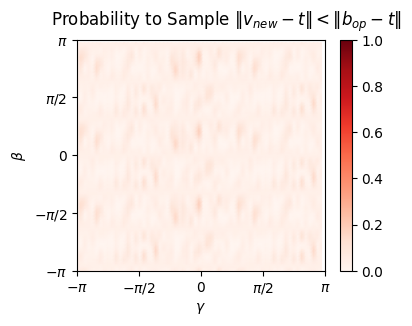

In [15]:
import matplotlib.pyplot as plt

cmap = 'Reds'

fig, ax2 = plt.subplots(figsize=(4, 3))
cbar2 = ax2.pcolormesh(values, values, heatmap, cmap=cmap, vmin=0, vmax=1, shading='gouraud')

# Aesthetics.
fig.suptitle('Probability to Sample $\|v_{new}-t\|<\|b_{op}-t\|$')
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$\\beta$')

# Custom tick labels.
ax2.set_xticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2_x_labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2_x_labels[0] = '$-\pi$'
ax2_x_labels[1] = '$-\pi/2$'
ax2_x_labels[2] = '0'
ax2_x_labels[3] = '$\pi/2$'
ax2_x_labels[4] = '$\pi$'
ax2.set_xticklabels(ax2_x_labels)

ax2.set_yticks([-np.pi, -np.pi/2, 0, np.pi/2, np.pi])
ax2_y_labels = [item.get_text() for item in ax2.get_yticklabels()]
ax2_y_labels[0] = '$-\pi$'
ax2_y_labels[1] = '$-\pi/2$'
ax2_y_labels[2] = '0'
ax2_y_labels[3] = '$\pi/2$'
ax2_y_labels[4] = '$\pi$'
ax2.set_yticklabels(ax2_y_labels)

# ColoUr bar.
fig.colorbar(cbar2)

plt.savefig('./figures/heatmap-5-qubits.pdf', bbox_inches='tight')
plt.show()

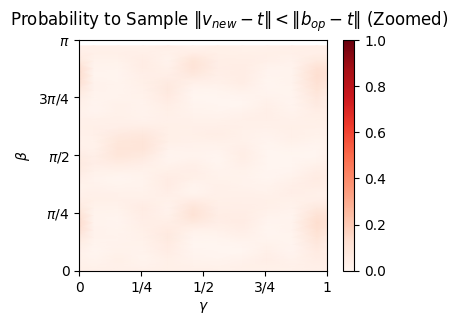

In [16]:
import matplotlib.pyplot as plt

cmap = 'Reds'

fig, ax2 = plt.subplots(figsize=(4, 3))
cbar2 = ax2.pcolormesh(values, values, heatmap, cmap=cmap, vmin=0, vmax=1, shading='gouraud')

# Constrain -- it looks pretty damn periodic.
ax2.set_xlim(0, 1)
ax2.set_ylim(0, np.pi)

# Aesthetics.
fig.suptitle('Probability to Sample $\|v_{new}-t\|<\|b_{op}-t\|$ (Zoomed)')
ax2.set_xlabel('$\gamma$')
ax2.set_ylabel('$\\beta$')

# Custom tick labels.
ax2.set_xticks([0, 1/4, 1/2, 3/4, 1])
ax2_x_labels = [item.get_text() for item in ax2.get_xticklabels()]
ax2_x_labels[0] = '0'
ax2_x_labels[1] = '1/4'
ax2_x_labels[2] = '1/2'
ax2_x_labels[3] = '3/4'
ax2_x_labels[4] = '1'
ax2.set_xticklabels(ax2_x_labels)

ax2.set_yticks([0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi])
ax2_y_labels = [item.get_text() for item in ax2.get_yticklabels()]
ax2_y_labels[0] = '0'
ax2_y_labels[1] = '$\pi/4$'
ax2_y_labels[2] = '$\pi/2$'
ax2_y_labels[3] = '$3\pi/4$'
ax2_y_labels[4] = '$\pi$'
ax2.set_yticklabels(ax2_y_labels)

# ColoUr bar.
fig.colorbar(cbar2)

plt.savefig('./figures/heatmap-5-qubits-zoomed.pdf', bbox_inches='tight')
plt.show()

## Plotting State Probabilities

In [15]:
# Chuck all the vectors into a list of 3-tuples with their distance to target and frequency.
solutions = [(v_new, np.linalg.norm(v_new - t), freq) for v_new, freq in zip(lattice_vectors, frequencies)]

# Sort the solutions by their distances to the target, shortest first.
solutions = sorted(solutions, key=lambda x : x[1])

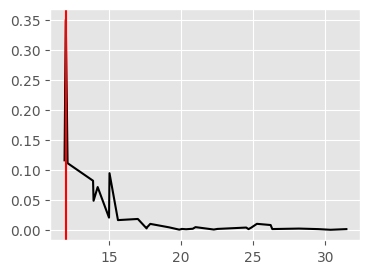

In [25]:
# Plot them in line plot -- they are pretty spread out so a bar plot is deceptive.
fig, ax = plt.subplots(figsize=(4, 3))

ax.plot([s[1] for s in solutions], [s[2] / n_samples for s in solutions], color='k')
ax.axvline(np.linalg.norm(residual_vector), color='r')